# Ocean Proximity as a Logistic Regression Problem with Mini_batch

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
%run 1.ReadingData.py

Name of the label file: OceanProximityOneHotEncodedClasses.csv
x_train: (16342, 9)
t_train: (16342, 4)
x_dev: (2043, 9)
t_dev: (2043, 4)
x_test: (2043, 9)
t_test: (2043, 4)


## Initialization

In [3]:
INPUTS = x_train.shape[1]
OUTPUTS = t_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(x_train.shape[0]/1))
NUM_DEV_EXAMPLES = int (round (x_dev.shape[0]/1))

Some data is displayed to test correctness:

In [4]:
INPUTS

9

In [5]:
OUTPUTS

4

In [6]:
NUM_TRAINING_EXAMPLES

16342

In [7]:
NUM_DEV_EXAMPLES

2043

In [8]:
x_train[:5]

array([[ 0.42031873, -0.66206164, -0.64705882, -0.69739051, -0.58752328,
        -0.82056672, -0.61914159, -0.69639039, -0.60742018],
       [ 0.43027888, -0.98087141, -0.01960784, -0.91784933, -0.91371819,
        -0.84629614, -0.91810557, -0.58127474, -0.78350192],
       [ 0.26294821, -0.72582359, -0.1372549 , -0.94485986, -0.91713222,
        -0.95392248, -0.91810557, -0.72952097, -0.15628802],
       [-0.44621514, -0.05632306, -0.49019608, -0.73401495, -0.74674115,
        -0.85251829, -0.73754317, -0.3834154 ,  0.09195838],
       [-0.39243028,  0.16471838, -0.41176471, -0.86189532, -0.80757294,
        -0.81277502, -0.78885052, -0.7176039 , -0.62350258]])

In [9]:
t_train[:5]

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [10]:
x_dev[:5]

array([[-0.07171315, -0.10733262, -0.1372549 , -0.89343303, -0.88081937,
        -0.94910171, -0.86712712, -0.58443332, -0.56041006],
       [-0.4123506 , -0.18384697,  0.49019608, -0.88371738, -0.83612663,
        -0.91894392, -0.86548265, -0.60979849, -0.27587515],
       [-0.61952191,  0.11583422,  1.        , -0.9123048 , -0.88112973,
        -0.96575016, -0.88324289, -0.56120605,  0.99999588],
       [ 0.45418327, -0.9957492 , -0.17647059, -0.88961799, -0.82557418,
        -0.88531069, -0.82798882, -0.79089944, -0.48742067],
       [ 0.15338645, -0.64930925,  0.33333333, -0.96032352, -0.95561763,
        -0.97634463, -0.95428383, -0.31657494, -0.23133925]])

In [11]:
t_dev[:5]

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

## Hyperparameters

A new hiperparameter has to be adjuted: the size of the mini-batch

In [12]:
n_epochs = 40000 
learning_rate = 0.1
batch_size = 200

In [13]:
n_learning_iterations = batch_size*n_epochs
n_learning_iterations

8000000

## Build the model: logistic classifier

In [14]:
X = tf.placeholder (dtype=tf.float32, shape=(None,INPUTS),name="X")
t = tf.placeholder (dtype=tf.float32, shape=(None,OUTPUTS), name="t")

In [15]:
W = tf.Variable (tf.random_uniform ([INPUTS,OUTPUTS],-1,1), name="W")
b = tf.Variable (tf.zeros([OUTPUTS]), name = "bias")

Compute the $logits$ (net), then the output with the $Softmax$ activation function:

In [16]:
net = tf.matmul(X,W)+b
y = tf.nn.softmax (logits=net, name="y")

The $log-loss$, $cross-entropy$ (the sun of log-loss is a loss) and and $cost$ (the mean of cross-entropy) functions:

In [17]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits (labels=t, logits=net)
mean_log_loss = tf.reduce_mean (cross_entropy, name="cost")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



The training algorithm: gradient descent method with a softmax function at the outputs:

In [18]:
train_step = tf.train.GradientDescentOptimizer (learning_rate).minimize(mean_log_loss)

Model evaluation: accuracy. The percentage of correctly classified instances.

In [19]:
correct_predictions = tf.equal(tf.argmax(y,1),tf.argmax(t,1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions,tf.float32))

## Execute the model M-BGD

In [20]:
init = tf.global_variables_initializer()
accuracy_train_history = np.empty([n_epochs])
with tf.Session() as sess:
    sess.run(init)
    for epoch in tqdm(range(n_epochs)):
        offset = (epoch * batch_size) % (NUM_TRAINING_EXAMPLES - batch_size)
        sess.run (train_step, feed_dict={X: x_train[offset:(offset+batch_size)],
                                         t: t_train[offset:(offset+batch_size)]})
        accuracy_train_history[epoch] = accuracy.eval(feed_dict={X: x_train[offset:(offset+batch_size)],
                                                                 t: t_train[offset:(offset+batch_size)]})
    accuracy_train = accuracy.eval(feed_dict={X: x_train[:NUM_TRAINING_EXAMPLES],
                                              t: t_train[:NUM_TRAINING_EXAMPLES]})
    accuracy_dev = accuracy.eval(feed_dict={X: x_dev[:NUM_DEV_EXAMPLES],
                                              t: t_dev[:NUM_DEV_EXAMPLES]})
    predictions = y.eval(feed_dict={X: x_dev[:NUM_DEV_EXAMPLES]})
    final_correct_preditions = correct_predictions.eval (feed_dict={X: x_dev[:NUM_DEV_EXAMPLES],
                                                                    t: t_dev[:NUM_DEV_EXAMPLES]})
    final_train_mean_log_loss = mean_log_loss.eval (feed_dict={X: x_train[:NUM_TRAINING_EXAMPLES],
                                              t: t_train[:NUM_TRAINING_EXAMPLES]})
    final_dev_mean_log_loss = mean_log_loss.eval (feed_dict={X: x_dev[:NUM_DEV_EXAMPLES],
                                              t: t_dev[:NUM_DEV_EXAMPLES]})

100%|██████████| 40000/40000 [00:39<00:00, 1002.93it/s]


In [21]:
"Final accuracy in training: " + str(accuracy_train)

'Final accuracy in training: 0.7961082'

In [22]:
"Maximum accuracy in training: " + str(np.max(accuracy_train_history))

'Maximum accuracy in training: 0.8849999904632568'

In [23]:
"Accuracy for the development set: " + str(accuracy_dev)

'Accuracy for the development set: 0.7983358'

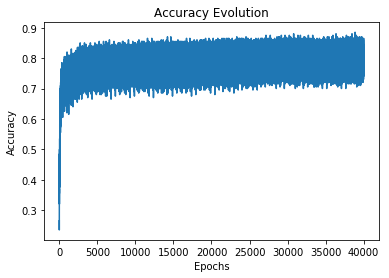

In [24]:
plt.title ("Accuracy Evolution")
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy")
plt.plot (range(n_epochs),accuracy_train_history)

Note that accuracy $zig$-$zags$ due to mini-batch $zig$-$zagging$ errors. 

In [25]:
predictions

array([[1.55194625e-02, 9.82724965e-01, 1.10980903e-03, 6.45698048e-04],
       [4.82209116e-01, 5.23199188e-03, 1.62414953e-01, 3.50143880e-01],
       [1.39123917e-01, 6.81051344e-04, 7.77952373e-01, 8.22426453e-02],
       ...,
       [5.33385158e-01, 1.00349545e-01, 2.34790221e-01, 1.31475091e-01],
       [3.24853271e-01, 3.20512027e-01, 3.37372601e-01, 1.72621198e-02],
       [7.17060566e-01, 1.59573972e-01, 3.01069720e-03, 1.20354801e-01]],
      dtype=float32)

In [26]:
rounded_predictions=np.round(predictions)
indices = np.argmax(predictions,1)
for row, index in zip(rounded_predictions, indices): row[index]=1
rounded_predictions[:10]

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [27]:
t_dev[:10]

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [28]:
final_correct_preditions[:10]

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True])

In [29]:
final_train_mean_log_loss

0.5683237

In [30]:
final_dev_mean_log_loss

0.5543795

<b>MBGD takes takes 20 secs. to achieve similar results</b> as those without mini-batch, which takes 1:40 for the same task. 500 epochs correspond to 20,500 iterations 